This dataset was published by C. Zhang, Q. Lin, C. Yang, Y. Kong, Z. Yu, and K. Liao and contains HTE data with 1H NMR yields for 47,000 amide coupling reactions using 96 different reaction conditions.

Reference: Chem. Sci. 2025, 16, 11809-11822.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys
from scipy.stats import ks_2samp

# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
hist_color = "#dfdfdf"
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14  # Legend titles
})

Load the data

In [2]:
data = pd.read_csv("amide_raw_experimental_data.csv",index_col=0, header=0)
# Ensure the SMILES strings are all canonical
for compound_class in ["sub_1_smiles","sub_2_smiles","product_smiles"]:
    data[compound_class] = data[compound_class].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x),canonical=True))
data.head()

,idx,condition_id,sub_1_smiles,sub_2_smiles,product_smiles,Activation_ID,Additive_ID,Base_ID,solvent_id,yield,yield_clf,name0,archive,train_or_test,y_pred,condition_SMILES,text
0,15635,84,Cc1ccc(N)nc1,O=C(O)c1cc2ccccc2s1,Cc1ccc(NC(=O)c2cc3ccccc3s2)nc1,R2,A5,B1,S1,0.431730,1,22003-30-1-PL26-LC1-C84,2208_1,train,0.385567,CC(C)N=C=NC(C)C.C1=CC2=C(N=C1)N(N=N2)O.CN(C)C=O,Cc1ccc(N)nc1.O=C(O)c1cc2ccccc2s1.CC(C)N=C=NC(C...
1,4731,28,NCc1ccc(F)cc1F,O=C(O)c1ccco1,O=C(NCc1ccc(F)cc1F)c1ccco1,R8,A7,B7,S1,0.720284,1,22003-14-1-PL26-LC1-C28,2208_1,train,0.690787,CCN=C=NCCCN(C)C.Cl.C1=CC=C2C(=C1)C(=O)N(C2=O)O...,NCc1ccc(F)cc1F.O=C(O)c1ccco1.CCN=C=NCCCN(C)C.C...
2,22762,12,NCc1ccc(Cl)cc1,O=C(O)c1cccc(-c2ccccc2)c1,O=C(NCc1ccc(Cl)cc1)c1cccc(-c2ccccc2)c1,R19,A1,B7,S1,0.510634,1,22003-33-1-PL24-LC1-C12,2209_3,train,0.423631,[B-](F)(F)(F)F.CN(C)C(=[N+](C)C)ON1C(=O)CCC1=O...,NCc1ccc(Cl)cc1.O=C(O)c1cccc(-c2ccccc2)c1.[B-](...
3,7892,21,COc1ccc(CN)cc1,CC(C(=O)O)c1ccc(-c2ccccc2)c(F)c1,COc1ccc(CNC(=O)C(C)c2ccc(-c3ccccc3)c(F)c2)cc1,R28,A4,B7,S1,0.812231,1,22003-18-1-PL19-LC1-C21,2208_1,train,0.768770,CN(C)C(=[N+](C)C)ON1C2=CC=CC=C2N=N1.F[P-](F)(F...,COc1ccc(CN)cc1.CC(C(=O)O)c1ccc(-c2ccccc2)c(F)c...
4,17450,75,COc1ccc(N)cn1,O=C(O)c1cccc(-c2ccccc2)c1,COc1ccc(NC(=O)c2cccc(-c3ccccc3)c2)cn1,R25,A1,B7,S1,0.872795,1,22003-31-1-PL9-LC1-C75,2208_1,train,0.829112,[B-](F)(F)(F)F.CN(C)C(=[N+](C)C)ON1C(=O)C2=CC=...,COc1ccc(N)cn1.O=C(O)c1cccc(-c2ccccc2)c1.[B-](F...


During our investigation, we found that one of the products in the dataset is not an amide. In light of the structures of the starting materials associated with this product, this is likely due to a typo leading to an additional carbon atom in the product.  We therefore changed the structure of this compound to the expected product of the amide coupling.

Non-amide product in the dataset:


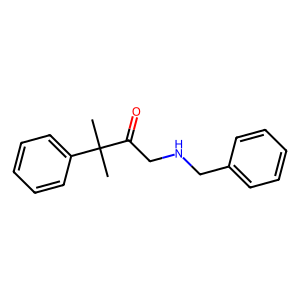

The above shown compound 'CC(C)(C(=O)CNCc1ccccc1)c1ccccc1' is in the list of products in the dataset.


In [3]:
non_amide_prod = "CC(C)(C(=O)CNCc1ccccc1)c1ccccc1"

print("Non-amide product in the dataset:")
depiction = Draw.MolToImage(Chem.MolFromSmiles(non_amide_prod))
display(depiction)

# confirm that it is actually in the dataset
if non_amide_prod in data["product_smiles"].to_list():
    print(f"The above shown compound '{non_amide_prod}' is in the list of products in the dataset.")
else:
    print(f"The above shown compound '{non_amide_prod}' is not in the dataset.")

In [4]:
# Find the starting materials associated with this product
data_non_amide = data[data["product_smiles"] == non_amide_prod]
print("Starting materials associated with this product:")
print(f'Amines: {data_non_amide["sub_1_smiles"].unique()}')
print(f'Acids: {data_non_amide["sub_2_smiles"].unique()}')

# Double check that this substrate combination only forms this product
prod_check = list(data[(data["sub_1_smiles"] == 'NCc1ccccc1') & (data["sub_2_smiles"] == 'CC(C)(C(=O)O)c1ccccc1')]["product_smiles"].unique())
print("Products associated with this substrate combination:", prod_check)


Starting materials associated with this product:
Amines: ['NCc1ccccc1']
Acids: ['CC(C)(C(=O)O)c1ccccc1']
Products associated with this substrate combination: ['CC(C)(C(=O)CNCc1ccccc1)c1ccccc1']


Reaction leading to the non-amide product:


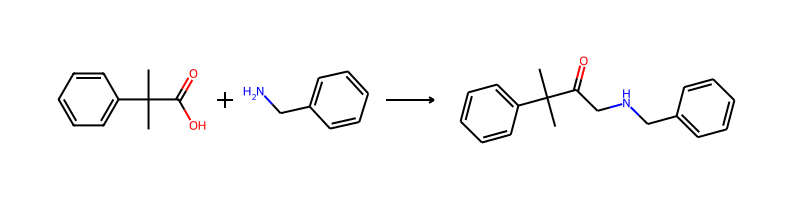

In [5]:
# Draw the reaction
reaction_smiles = f"CC(C)(C(=O)O)c1ccccc1.NCc1ccccc1>>{non_amide_prod}"
rxn = rdChemReactions.ReactionFromSmarts(reaction_smiles, useSmiles=True)
print("Reaction leading to the non-amide product:")
Draw.ReactionToImage(rxn)

Modification of the structure in the dataset:


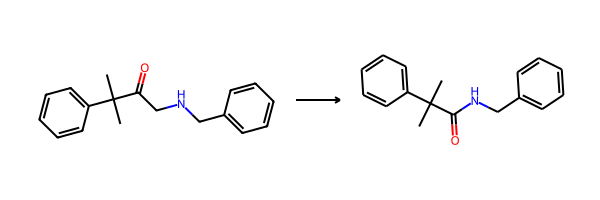

The compound 'CC(C)(C(=O)CNCc1ccccc1)c1ccccc1' is not in the dataset anymore.
It was replaced with the compound 'CC(C)(C(=O)NCc1ccccc1)c1ccccc1'.


In [6]:
# Replace the product structure
print("Modification of the structure in the dataset:")
updated_smiles = Chem.MolToSmiles(Chem.MolFromSmiles("CC(C)(C(=O)NCc1ccccc1)c1ccccc1"),canonical=True)
data["product_smiles"] = data["product_smiles"].replace(non_amide_prod, updated_smiles)
rxn = rdChemReactions.ReactionFromSmarts(f"{non_amide_prod}>>{updated_smiles}", useSmiles=True)
display(Draw.ReactionToImage(rxn))

# confirmation that the replacement worked
if non_amide_prod in data["product_smiles"].to_list():
    print(f"The compound '{non_amide_prod}' is in the list of products in the dataset.")
else:
    print(f"The compound '{non_amide_prod}' is not in the dataset anymore.")
    if updated_smiles in data["product_smiles"].to_list():
        print(f"It was replaced with the compound '{updated_smiles}'.")

In [7]:
# save this processed version of the dataset
data.to_csv("amide_proc_experimental_data.csv",index=True,header=True)

Analyze product counts and the overall number of substrates

In [ ]:
product_smiles = data["product_smiles"].unique().tolist()
print(f"There are {len(product_smiles)} different products in the full dataset.")
# convert to canonical smiles and save
product_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smiles),canonical=True) for smiles in product_smiles]
pd.DataFrame(product_smiles).to_csv("./Datasets/0_Descriptor_Generation/amide_smiles_products.csv",index=False,header=True)

acid_smiles = data["sub_2_smiles"].unique().tolist()
print(f"There are {len(acid_smiles)} different acids in the full dataset.")
# convert to canonical smiles and save
acid_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smiles),canonical=True) for smiles in acid_smiles]

pd.DataFrame(acid_smiles).to_csv("./Datasets/0_Descriptor_Generation/amide_smiles_substrates_acids.csv",index=False,header=True)
amine_smiles = data["sub_1_smiles"].unique().tolist()
print(f"There are {len(amine_smiles)} different amines in the full dataset.")
# convert to canonical smiles and save
amine_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smiles),canonical=True) for smiles in amine_smiles]
pd.DataFrame(amine_smiles).to_csv("./Datasets/0_Descriptor_Generation/amide_smiles_substrates_amines.csv",index=False,header=True)


There are 632 different products in the full dataset.
There are 66 different acids in the full dataset.
There are 70 different amines in the full dataset.


Acid substrates:


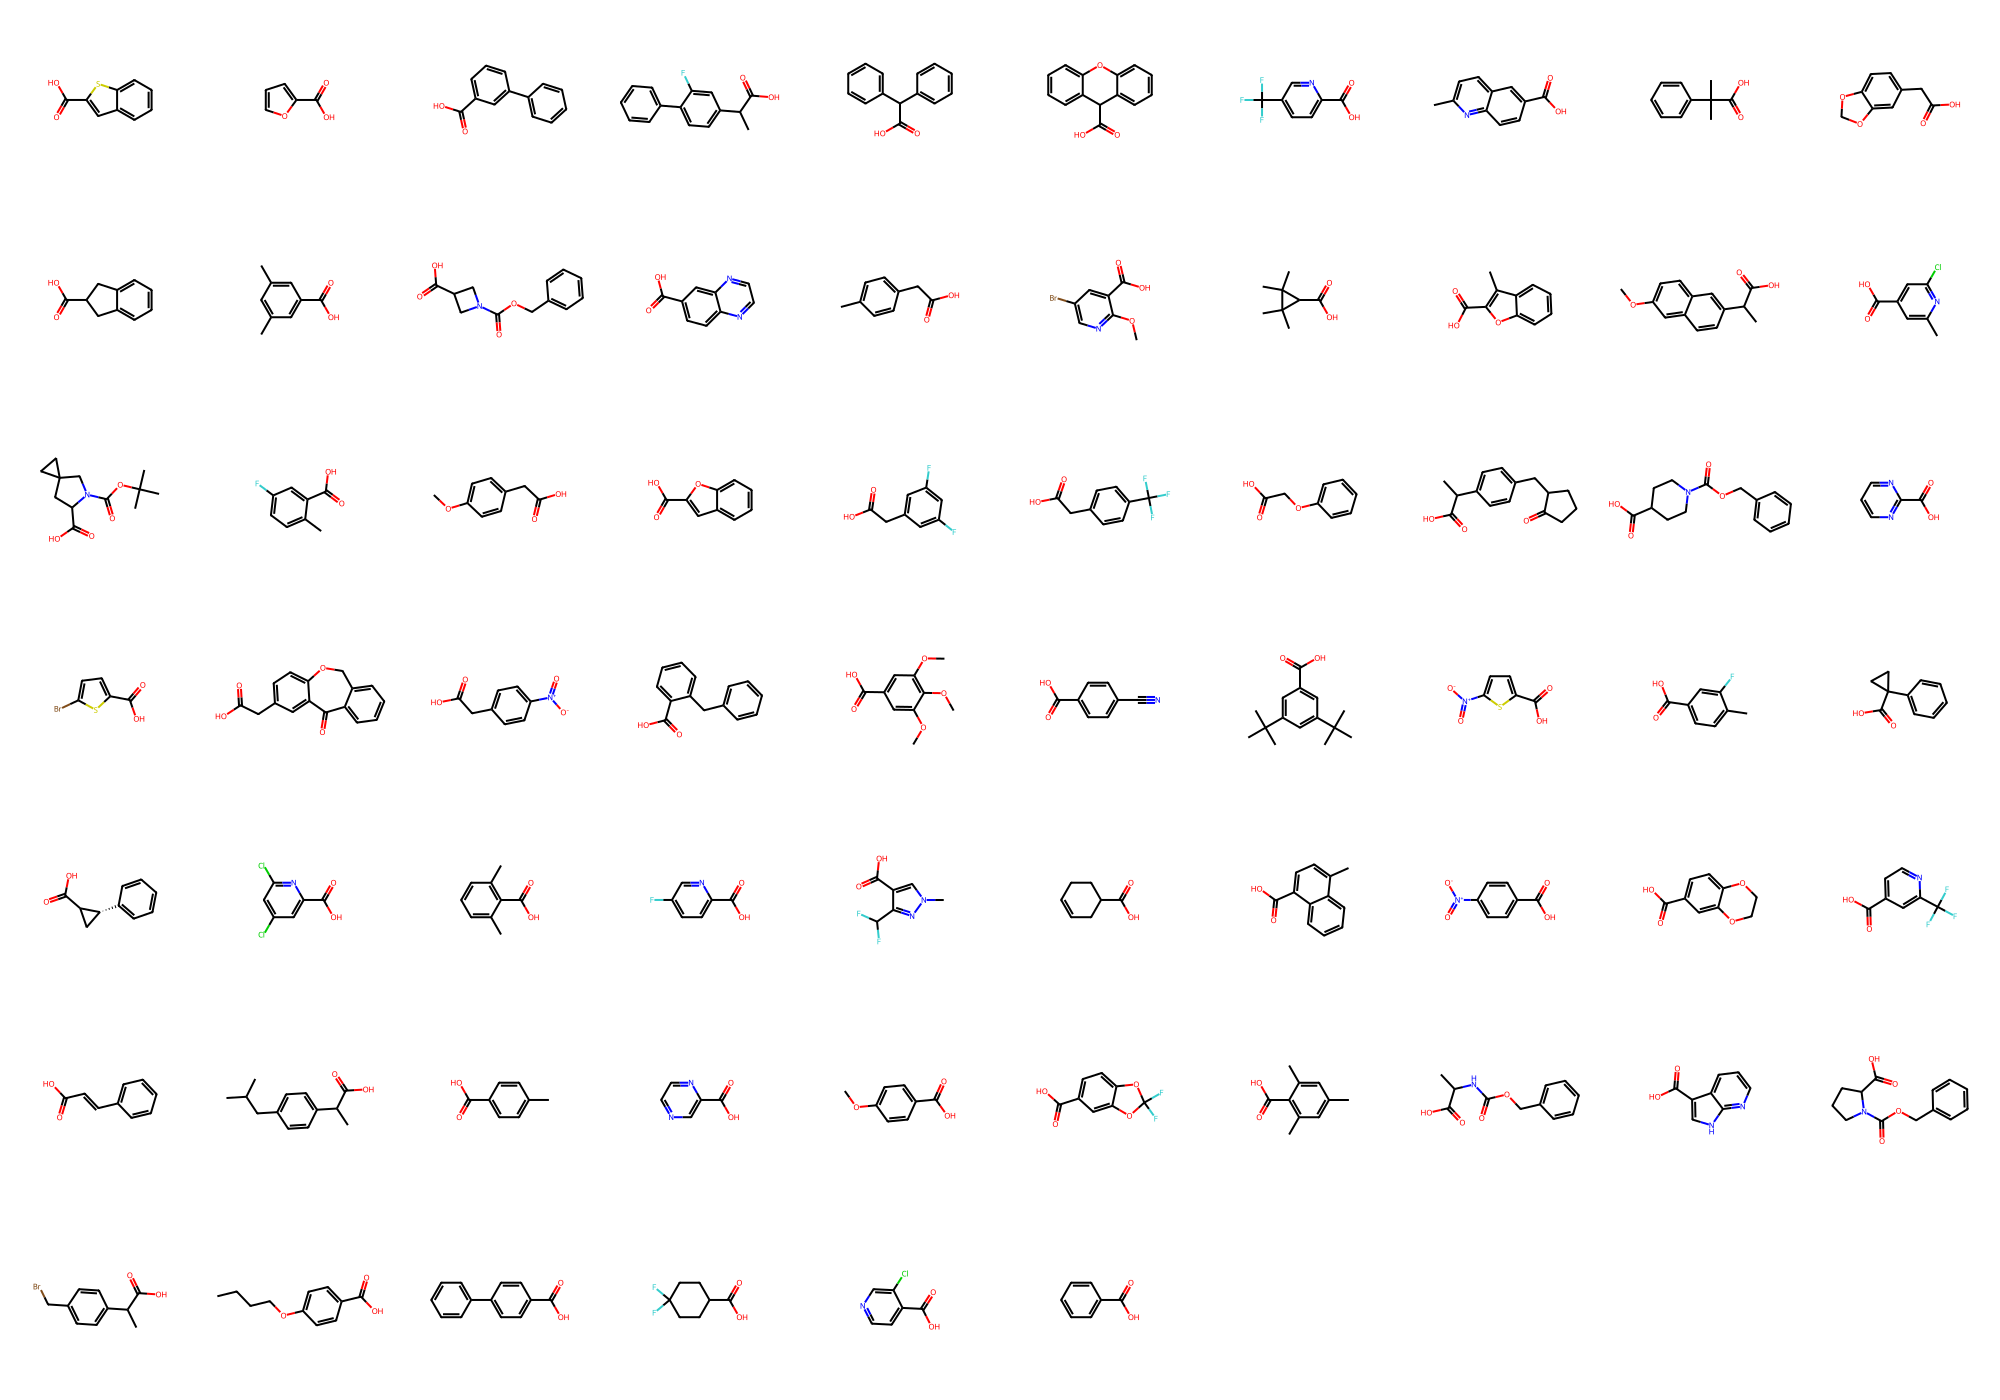

In [9]:
# Visualize the substrates
Draw.IPythonConsole.maxMols = 70
print("Acid substrates:")
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles) for smiles in acid_smiles],
    molsPerRow=10,
    subImgSize=(200, 200),
    maxMols=70
    )

Amine substrates:


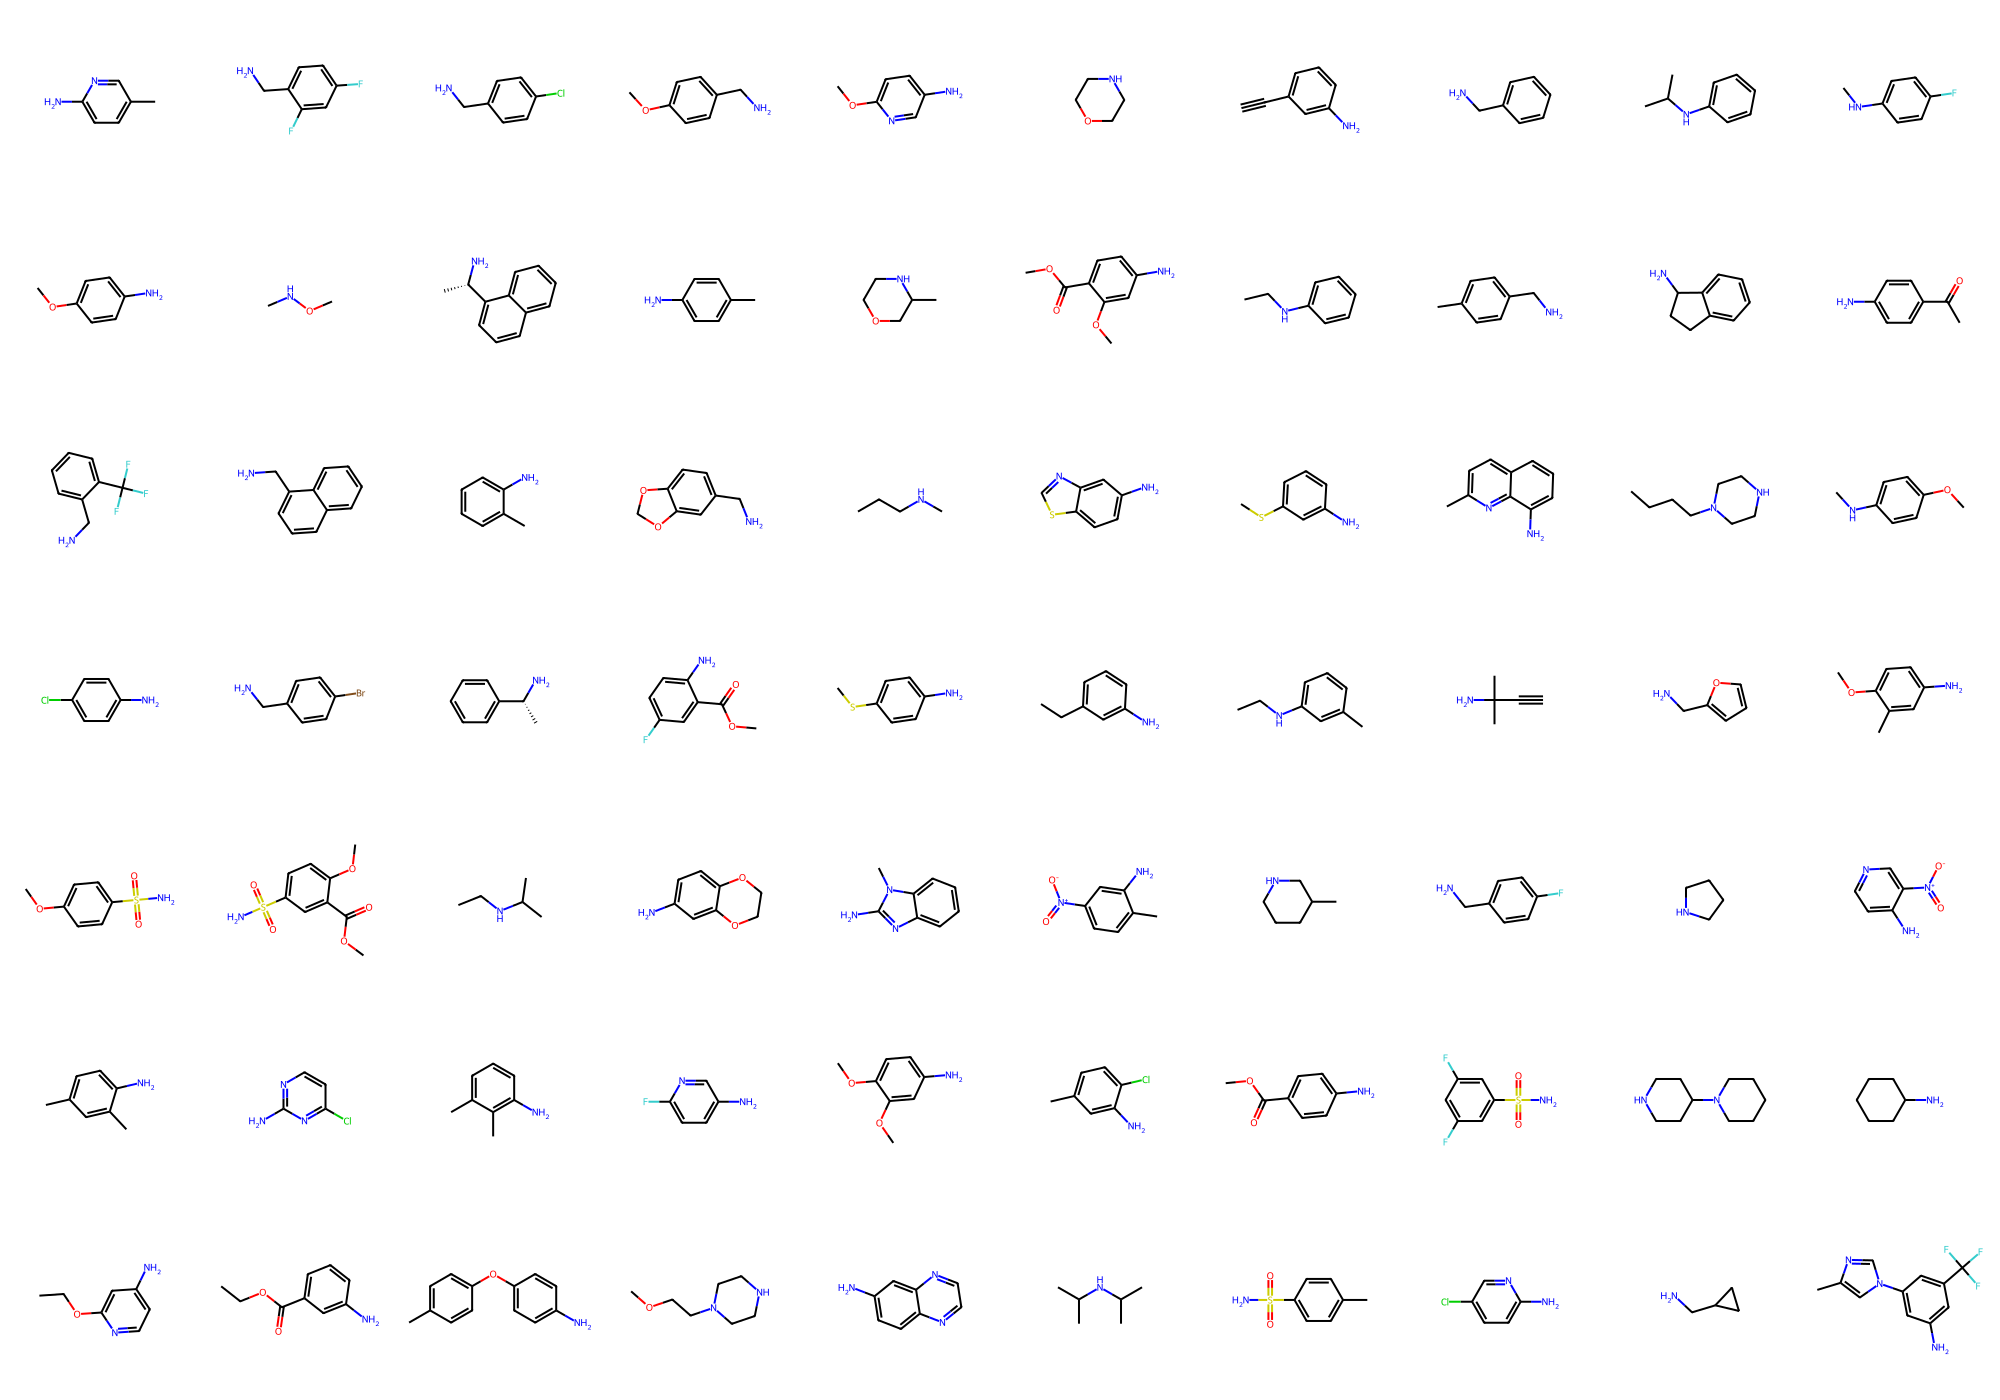

In [10]:
print("Amine substrates:")
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles) for smiles in amine_smiles],
    molsPerRow=10,
    subImgSize=(200, 200),
    maxMols=70
    )

Number of products for the different conditions:


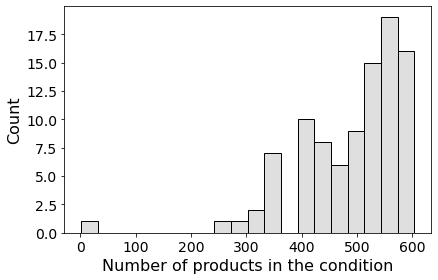

Maximum amount of products for one condition: 604 out of a maximum of 632.



In [11]:
rxn_per_cond = []
for cond in range(1,96):
    count = data["condition_id"].value_counts().get(cond, 0)
    rxn_per_cond.append(count)
print("Number of products for the different conditions:")
plt.figure(figsize=(6, 4))
plt.hist(rxn_per_cond, color=hist_color, bins=20, edgecolor="k")
plt.xlabel("Number of products in the condition")
plt.ylabel("Count")
plt.tick_params(axis='both', which='major')
plt.tight_layout()
plt.show()
print(f"Maximum amount of products for one condition: {max(rxn_per_cond)} out of a maximum of 632.")
print("")


Look at some of the conditions with the most products

In [ ]:
# sort the conditions by product count
sorted_by_count = [rxn for rxn in rxn_per_cond]
sorted_by_count.sort(reverse=True)
print("Number of products for the 4 conditions with the most products:")
sorted_by_count[:4]

[604, 600, 599, 591]

In [13]:
# Get the condition IDs for these largest sub-datasets (NOTE: the condition_id's are 1-indexed)
ids_top_cond = [rxn_per_cond.index(prod_numb)+1 for prod_numb in sorted_by_count[:4]]
print(f"Conditions with the most products: {ids_top_cond}")

Conditions with the most products: [23, 20, 37, 13]


In [14]:
print("Number of different substrates used in these conditions:")
for id in ids_top_cond:
    sub_data = data.loc[data["condition_id"] == id]
    print(f'Condition {id}: {len(sub_data["sub_1_smiles"].unique())} amines and {len(sub_data["sub_2_smiles"].unique())} acids')

Number of different substrates used in these conditions:
Condition 23: 69 amines and 66 acids
Condition 20: 70 amines and 66 acids
Condition 37: 69 amines and 66 acids
Condition 13: 69 amines and 65 acids


These condtions all use either all or almost all possible substrates.

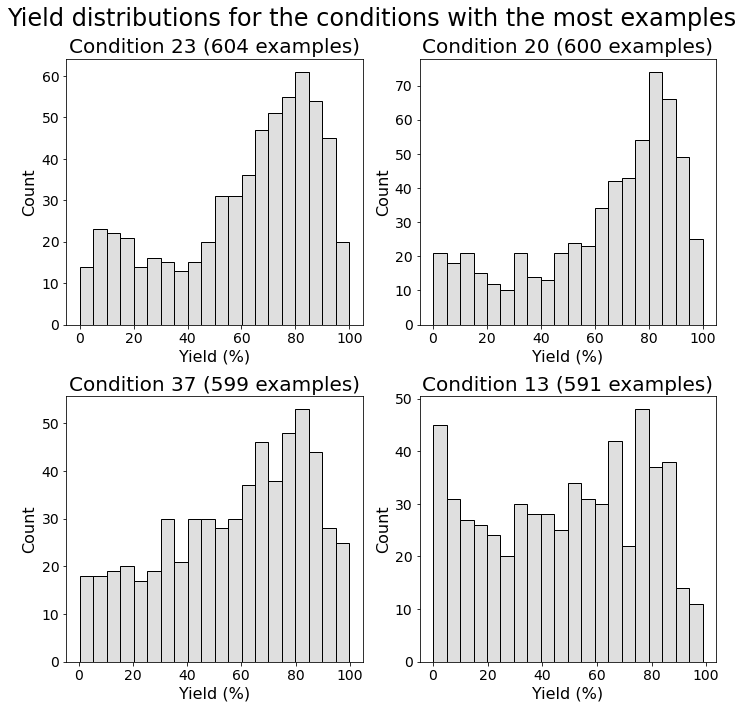

Average yield for these conditions:
Condition 23: 61%
Condition 20: 63%
Condition 37: 58%
Condition 13: 48%
Percentage of low-performing examples for these conditions (<10%):
Condition 23: 6%
Condition 20: 6%
Condition 37: 6%
Condition 13: 13%


In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=False)
fig.suptitle("Yield distributions for the conditions with the most examples")
axes = axes.flatten()

for i in range(4):
    sub_data = data.loc[data["condition_id"] == ids_top_cond[i]]
    axes[i].hist(sub_data["yield"]*100, color=hist_color, bins=20, edgecolor="k")
    axes[i].set_xlabel("Yield (%)")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='both', which='major')
    axes[i].set_title(f"Condition {ids_top_cond[i]} ({len(sub_data)} examples)")

plt.tight_layout()
plt.show()

print("Average yield for these conditions:")
for id in ids_top_cond:
    sub_data = data.loc[data["condition_id"] == id]
    print(f'Condition {id}: {round(sub_data["yield"].mean()*100)}%')
print("Percentage of low-performing examples for these conditions (<10%):")
for id in ids_top_cond:
    sub_data = data.loc[data["condition_id"] == id]
    print(f'Condition {id}: {round(len(sub_data[sub_data["yield"] < 0.10])/len(sub_data)*100)}%')

The three conditions with the most examples have a similar data distribution and all exhibit a high overall yield, with condition 20 having the highest average yield and only 4 fewer examples than the conditions with the most examples (condition 23).

Checking for other conditions with many (≥550) examples and an even higher average yield:

In [16]:
conditions_high_performance = []
for condition_id in data["condition_id"].unique():
    if len(data[data["condition_id"] == condition_id]) >= 550:
        if data[data["condition_id"] == condition_id]["yield"].mean() >= 0.63:
            conditions_high_performance.append(condition_id)
if conditions_high_performance:
    print(f"These condtions have a higher average yield than conditions 20 and more than 550 examples: {conditions_high_performance}.")
else:
    print("No condition with 550 or more examples has a higher average yield than condition 20.")

No condition with 550 or more examples has a higher average yield than condition 20.


Check for conditions with many (≥550) examples and a poor overall performance (average yield ≤25%):

In [17]:
for condition_id in data["condition_id"].unique():
    if len(data[data["condition_id"] == condition_id]) >= 550:
        if data[data["condition_id"] == condition_id]["yield"].mean() <= 0.25:
            print(f"This condition has more than 550 examples and an average below 25%: {condition_id}")

This condition has more than 550 examples and an average below 25%: 87


Visualize this low-performing dataset:

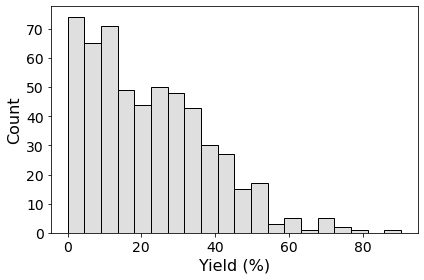

Data distribution for condition 87 (551 examples):

Average yield for this sub-dataset: 22%
Percentage of low-performing examples for these conditions (<10%): 29%


In [18]:
# Some information for this sub-dataset:
sub_data = data.loc[data["condition_id"] == 87]
plt.figure(figsize=(6, 4))
plt.hist(sub_data["yield"]*100, color=hist_color, bins=20, edgecolor="k")
plt.xlabel("Yield (%)")
plt.ylabel("Count")
plt.tick_params(axis='both', which='major')
plt.tight_layout()
plt.show()
print(f"Data distribution for condition 87 ({len(sub_data)} examples):\n")
print(f'Average yield for this sub-dataset: {round(sub_data["yield"].mean()*100)}%')
print(f'Percentage of low-performing examples for these conditions (<10%): {round(len(sub_data[sub_data["yield"] < 0.10])/len(sub_data)*100)}%')

Check for conditions with many (≥550) examples and a mediocre overall performance (35% ≤ average yield ≤ 45%):

In [19]:
for condition_id in data["condition_id"].unique():
    if len(data[data["condition_id"] == condition_id]) >= 550:
        if data[data["condition_id"] == condition_id]["yield"].mean() <= 0.45 and data[data["condition_id"] == condition_id]["yield"].mean() >= 0.35:
            print(f"This condition has more than 550 examples and an average yield between 35% and 45% percent: {condition_id}")

This condition has more than 550 examples and an average yield between 35% and 45% percent: 24


Visualize this condition with mediocre performance:

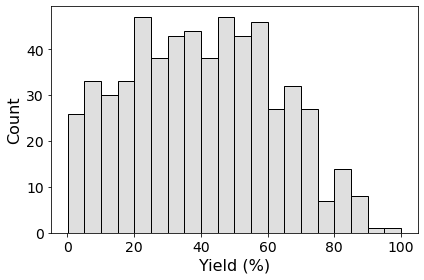

Data distribution for condition 24 (585 examples):
Average yield for this sub-dataset: 40%
Percentage of low-performing examples for these conditions (<10%): 10%


In [20]:
# Information for this sub-dataset
sub_data = data.loc[data["condition_id"] == 24]
plt.figure(figsize=(6, 4))
plt.hist(sub_data["yield"]*100, color=hist_color, bins=20, edgecolor="k")
plt.xlabel("Yield (%)")
plt.ylabel("Count")
plt.tick_params(axis='both', which='major')
plt.tight_layout()
plt.show()
print(f"Data distribution for condition 24 ({len(sub_data)} examples):")
print(f'Average yield for this sub-dataset: {round(sub_data["yield"].mean()*100)}%')
print(f'Percentage of low-performing examples for these conditions (<10%): {round(len(sub_data[sub_data["yield"] < 0.10])/len(sub_data)*100)}%')

There are reaction conditions in the dataset that give high, medium, and low performance and that all have many examples.

The three sub-datasets for these three condtions could be used to analyze the effect of the dataset distribution on the algorithm performance using a real-world example. While all three sub-datasets have many examples, it would be good if they could have the same exact product examples to make this analysis more meaningful.

Let's see how many examples are shared between these three sub-datasets and how the yield distribution looks like for that shared set of products.

There are 522 shared products among these three conditions.


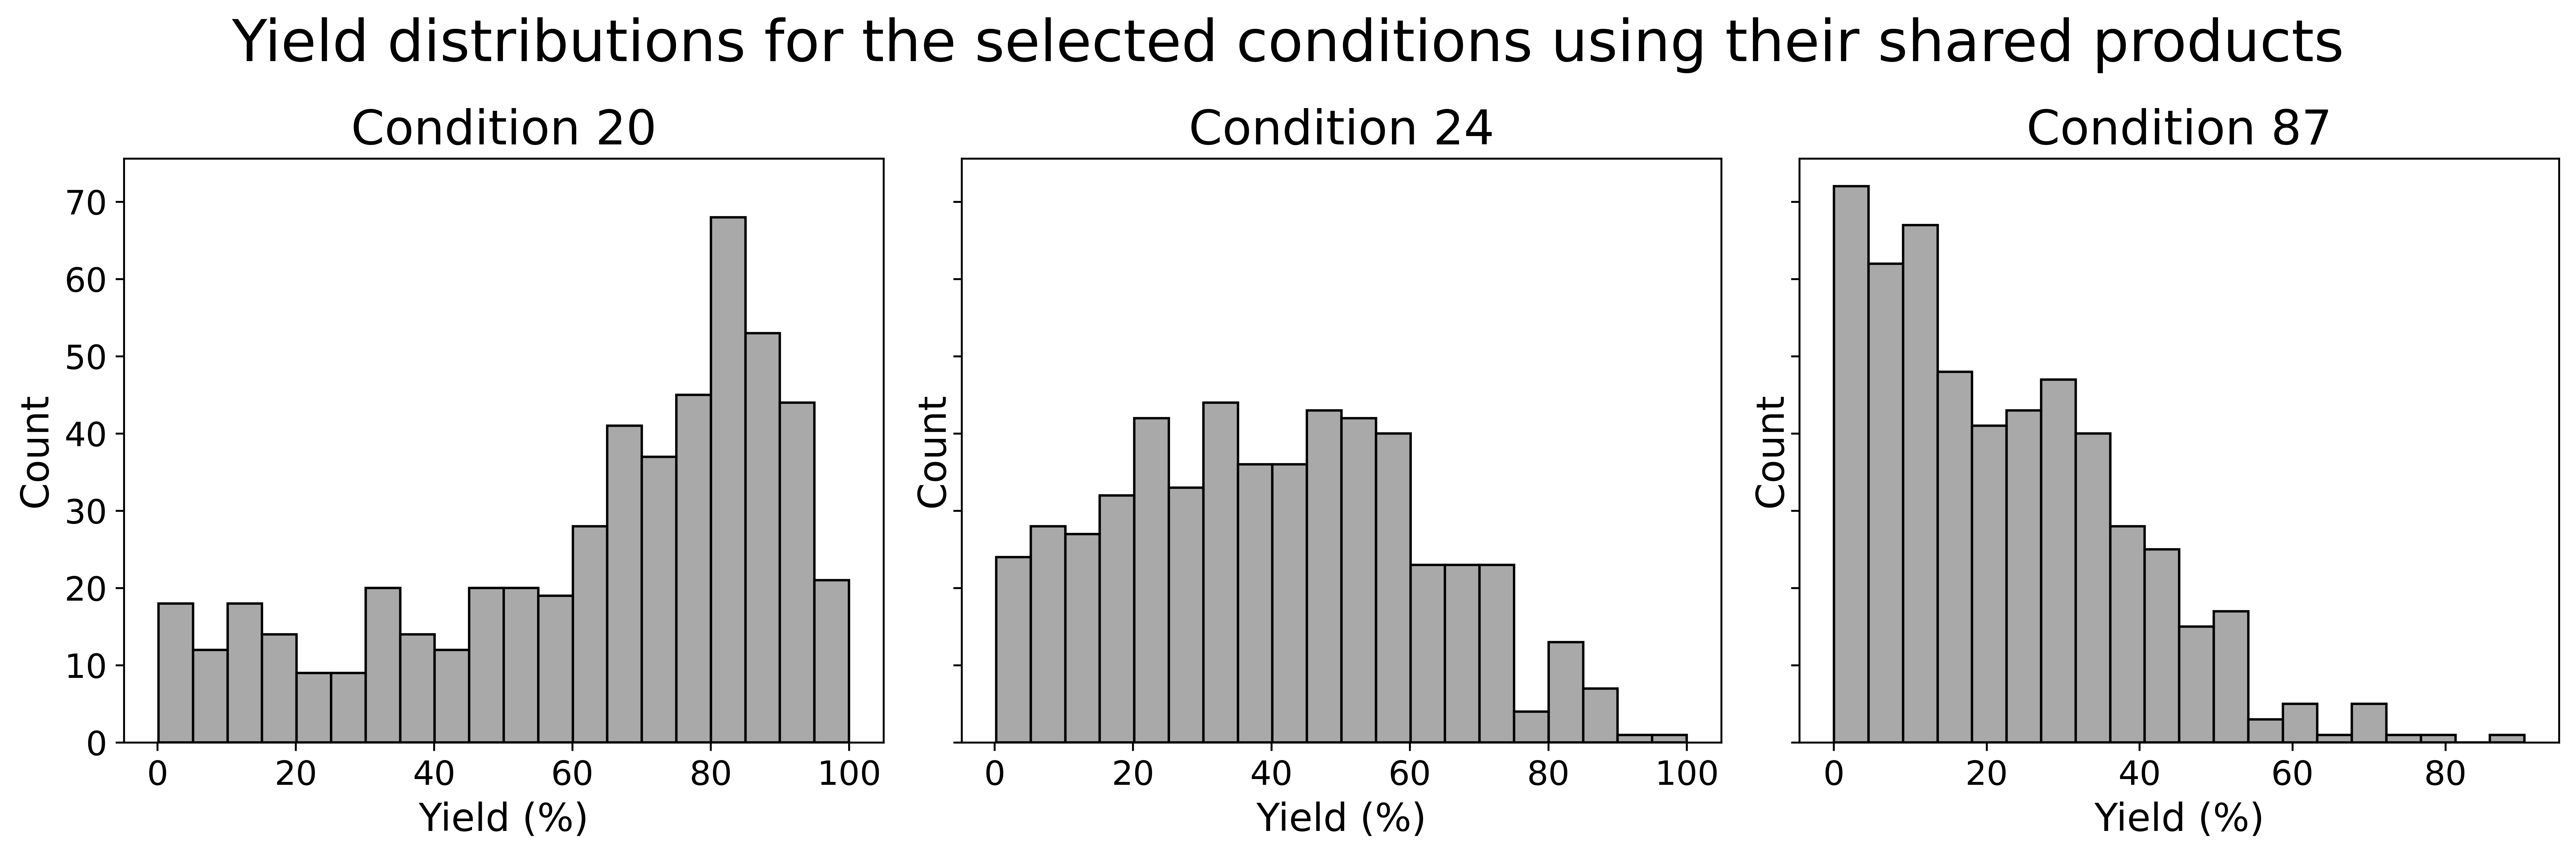

Average yield for these conditions:
Condition 20: 62.97%
Condition 24: 39.84%
Condition 87: 22.16%
Percentage of low-performing examples for these conditions (<10%):
Condition 20: 5%
Condition 24: 8%
Condition 87: 26%


In [21]:
# Define the reaction conditions of interest.
condition_ids = [20,24,87]
condition_data_shared_products = {}
# Get the shared products.
shared_data = data[data["condition_id"].isin(condition_ids)]
product_sets = shared_data.groupby("condition_id")["product_smiles"].apply(set)
shared_products = set.intersection(*product_sets)
print(f"There are {len(shared_products)} shared products among these three conditions.")

def condition_data(figsize=(15,5),show_labels=True):
    fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True, dpi=600)
    if show_labels:
        fig.suptitle("Yield distributions for the selected conditions using their shared products")

    for idx,cond_id in enumerate(condition_ids):
        cond_data = data.loc[data["condition_id"] == cond_id]  # get the data for the condtion
        condition_data_shared_products[cond_id] = cond_data[cond_data["product_smiles"].isin(shared_products)] # only keep the shared products
        # remove potential reaction duplicates by forming their average
        condition_data_shared_products[cond_id] = condition_data_shared_products[cond_id].groupby('product_smiles', as_index=False).agg({'yield': 'mean'})
        axes[idx].hist(condition_data_shared_products[cond_id]["yield"]*100, color=all_colors[6], bins=20, edgecolor="k")
        if show_labels:
            axes[idx].set_xlabel("Yield (%)")
            axes[idx].set_ylabel("Count")
            axes[idx].tick_params(axis='both', which='major')
            axes[idx].set_title(f"Condition {ids_top_cond[i]} ({len(sub_data)} examples)")
            axes[idx].set_title(f"Condition {cond_id}")
            axes[idx].set_xlabel("Yield (%)")
            axes[idx].set_ylabel("Count")
        else:
            axes[idx].set_xticks([])
            axes[idx].set_yticks([])
    plt.tight_layout()
    plt.show()

condition_data()

print("Average yield for these conditions:")
for id in condition_ids:
    print(f'Condition {id}: {round(condition_data_shared_products[id]["yield"].mean()*100,2)}%')
print("Percentage of low-performing examples for these conditions (<10%):")
for id in condition_ids:
    print(f'Condition {id}: {round(len(condition_data_shared_products[id][condition_data_shared_products[id]["yield"] < 0.10])/len(sub_data)*100)}%')

Reprint for manuscript

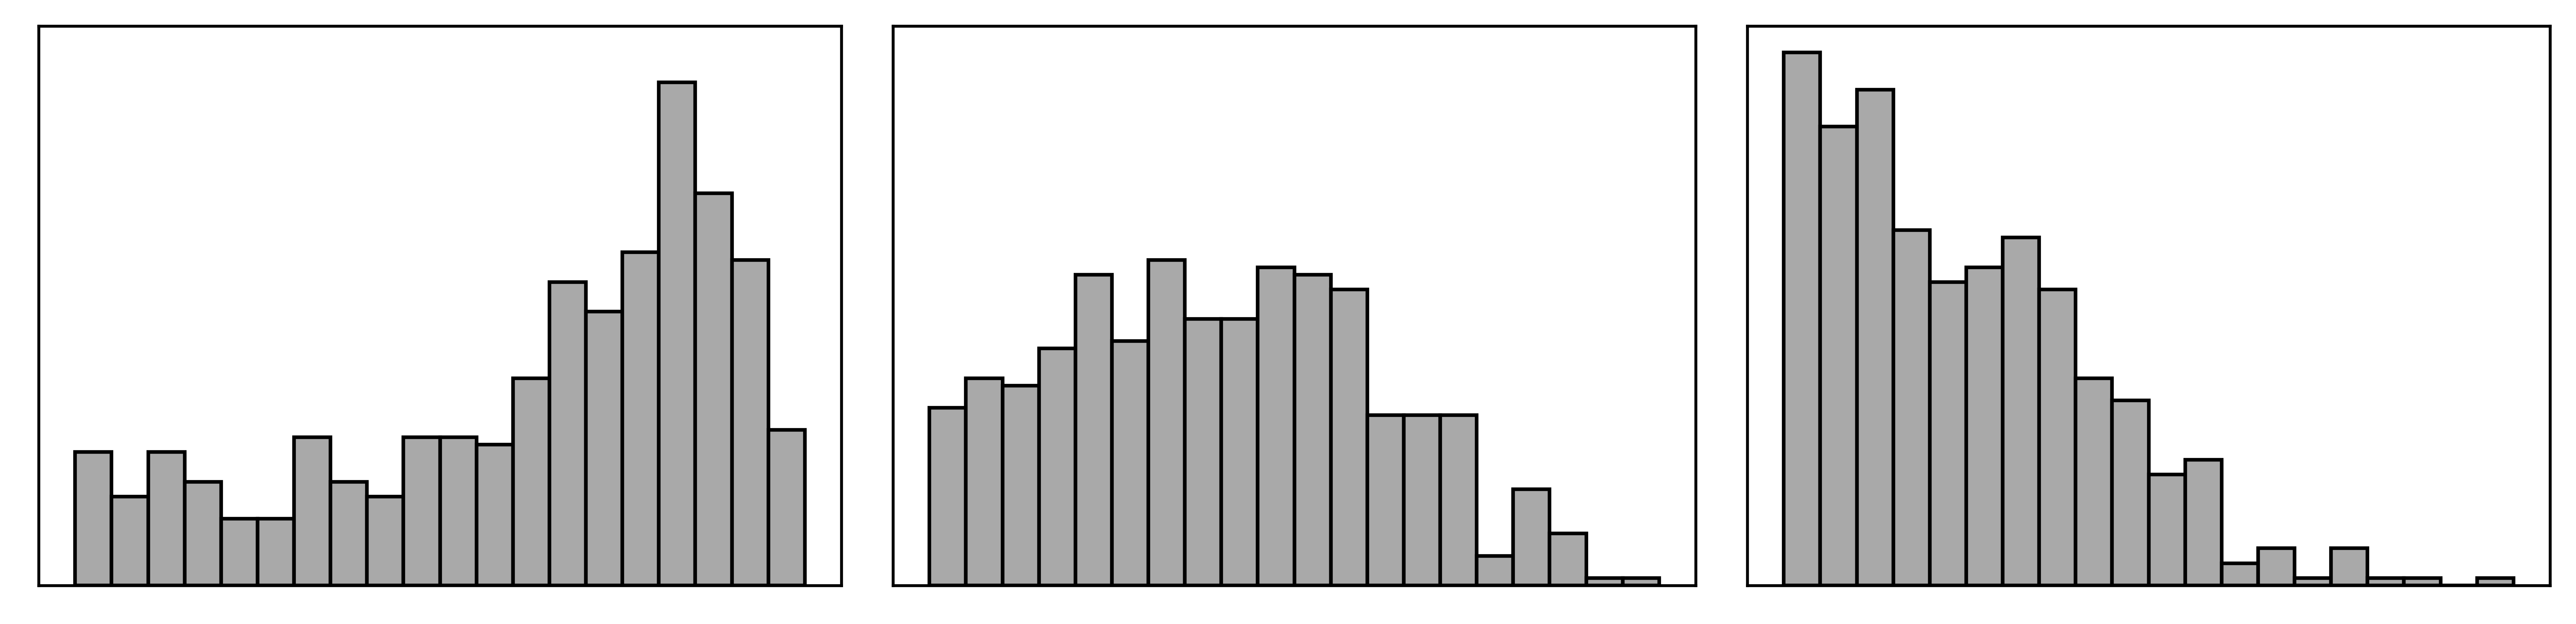

In [22]:
condition_data(figsize=(10,2.5),show_labels=False)

The sub-dataset distributions for all these subsets remain almost the same and the number of shared products is only a bit lower than the original number of products for these condition datasets (522 products), enabling us to use the subsets for the envisioned analysis of the dataset distribution.

In [ ]:
# make a df for the shared products and the corresponding substrate combination
df_prods = pd.DataFrame(shared_products, columns = ["Products"])
# assign the substrate combination
for idx in df_prods.index:
    amine = data[data["product_smiles"] == df_prods.loc[idx,"Products"]]["sub_1_smiles"].unique()[0]
    acid = data[data["product_smiles"] == df_prods.loc[idx,"Products"]]["sub_2_smiles"].unique()[0]
    df_prods.loc[idx,"Combination"] = f"{amine}.{acid}"
df_prods.head(3)

,Products,Combination
0,CC(=O)c1ccc(NC(=O)C2CC3(CC3)CN2C(=O)OC(C)(C)C)cc1,CC(=O)c1ccc(N)cc1.CC(C)(C)OC(=O)N1CC2(CC2)CC1C...
1,Cc1ccc(CC(=O)N(C)c2ccc(F)cc2)cc1,CNc1ccc(F)cc1.Cc1ccc(CC(=O)O)cc1
2,O=C(Cc1cc(F)cc(F)c1)Nc1ccc2scnc2c1,Nc1ccc2scnc2c1.O=C(O)Cc1cc(F)cc(F)c1


In [ ]:
# save it
df_prods.to_csv(index = False, header = False,
                path_or_buf="./Datasets/0_Descriptor_Generation/amide_smiles_products_filtered.csv")

The datasets are visually fairly similar to the ArI optimization datasets. We therefore compared the datasets with a Kolmogorov-Smirnov test to see if the distribution shapes are the same.

In [25]:
def normalize(data):
    min_val = data.min()
    max_val = data.max()
    return data.apply(lambda x: (x- min_val) / (max_val - min_val))

print("Kolmogorov-Smirnov analysis for the amide datasets compared to the ArI datasets with similar distributions:\n")
for dset in ["high","medium","low"]:
    print(f"{dset} datasets:")
    df_ari = pd.read_csv(f"./../../dataset_ArI/0_Data/Datasets/Datasets_Hyperpar_Opt/data-{dset}.csv",index_col=0)

    df_amide = pd.read_csv(f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv",index_col=0)

    statistic, p_value = ks_2samp(normalize(df_ari["rate"]), normalize(df_amide["yield"]))

    print("KS statistic:", statistic)
    print("p value:", p_value)
    print("")

print("Note: The data was normalized to only compare the distribution shape.")


Kolmogorov-Smirnov analysis for the amide datasets compared to the ArI datasets with similar distributions:

high datasets:
KS statistic: 0.2033325869532766
p value: 1.0306049046295826e-10

medium datasets:
KS statistic: 0.2848700953659423
p value: 2.6142725589120627e-30

low datasets:
KS statistic: 0.13989146801437155
p value: 2.226627701137857e-06

Note: The data was normalized to only compare the distribution shape.


The Kolmogorov-Smirnov tests indicate the distribution shapes for the amide and ArI datasets are not the same as the null hypothesis is rejected (p < 0.05 for all datasets.)